In [1]:
from sklearn.svm import LinearSVC
import glob
import numpy as np
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
from cv_utils import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import os.path
from lane_utils import *

# Read dataset

In [2]:
car_images = glob.glob('data/vehicles/**/**/*.png')
non_car_images = glob.glob('data/non-vehicles/**/**/*.png')

print ('Car Images dataset size:', len(car_images))
print ('Non-car Images dataset size:', len(non_car_images))

Car Images dataset size: 8792
Non-car Images dataset size: 8968


# Hog features

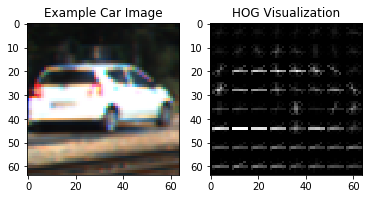

In [3]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image


image = mpimg.imread(car_images[ind])

feature_image = convert_color_space(image)

    
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(feature_image, orient=9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


# Spatian Binning

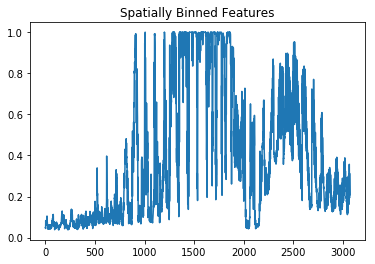

In [4]:
feature_vec = bin_spatial(feature_image, size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

# Define Parameters

In [5]:

### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()


# Extract hog and spatially binned features (combined)

In [6]:
import pickle 


if not os.path.exists('car_features.pkl'):
    car_features = get_image_features(car_images, 
                                      color_space=color_space, 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell,
                                      cell_per_block=cell_per_block,
                                      hog_channel=hog_channel,
                                      spatial_size=spatial_size,
                                      hist_bins=hist_bins, 
                                      spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat,
                                      hog_feat=hog_feat)
    
    with open('car_features.pkl', 'wb') as pickle_file:
        pickle.dump(car_features, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
else : 
    with open('car_features.pkl', 'rb') as pickle_load:
        car_features = pickle.load(pickle_load)
        


if not os.path.exists('not_car_features.pkl'):
    not_car_features = get_image_features(non_car_images, 
                                      color_space=color_space, 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell,
                                      cell_per_block=cell_per_block,
                                      hog_channel=hog_channel,
                                      spatial_size=spatial_size,
                                      hist_bins=hist_bins, 
                                      spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat,
                                      hog_feat=hog_feat)



    with open('not_car_features.pkl', 'wb') as pickle_file:
        pickle.dump(not_car_features, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('not_car_features.pkl', 'rb') as pickle_load:
        not_car_features = pickle.load(pickle_load)

# Show Raw and Normalized Features

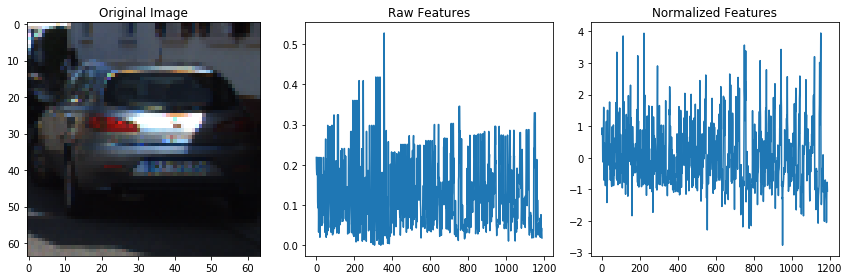

In [7]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, not_car_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(car_images))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_images[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

# Generate dataset and train the model

In [8]:
from sklearn.externals import joblib
if not os.path.exists('model.pkl'):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, not_car_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

    print(X.shape)
    print(y.shape)
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    
    #save the model
    joblib.dump(svc, 'model.pkl') 
else:
    svc = joblib.load('model.pkl')

# Custom image example of find rectangles

In [9]:
from scipy.ndimage.measurements import label

image = mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

ystart = 400
ystop = 656
scale = 1.5
    
rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)  

print(rectangles)

[((834, 400), (930, 496)), ((978, 400), (1074, 496)), ((1074, 400), (1170, 496))]


# Sliding Window Example

((834, 400), (930, 496))
((882, 400), (978, 496))
((1026, 400), (1122, 496))
((834, 400), (962, 528))
((1026, 400), (1154, 528))
((1090, 400), (1218, 528))
Number of boxes:  6


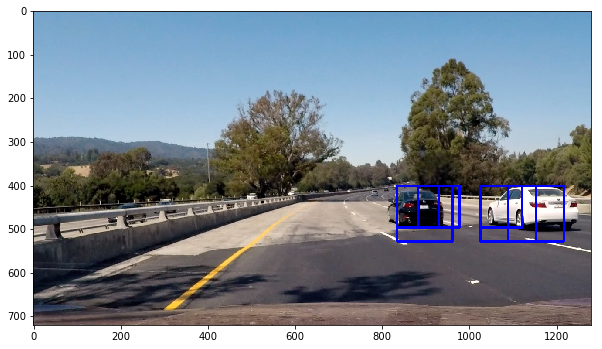

In [33]:
def draw_labeled_boxes(img, bboxes):
    imcopy = np.copy(img)
    random_color = False
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0, 0, 255), thick)
    # Return the image copy with boxes drawn
    return imcopy

test_img = mpimg.imread('test_images/test4.jpg')
rects = []

iter_list=[400,500,1.5,400,550,2.0,400,600,3.5]


for i in range(0,len(iter_list)-3, 3):
    ystart = iter_list[i]
    ystop = iter_list[i+1]
    scale = iter_list[i+2]
    rectangle = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)  
    rects.append(rectangle)
        

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))


# Sliding window searches

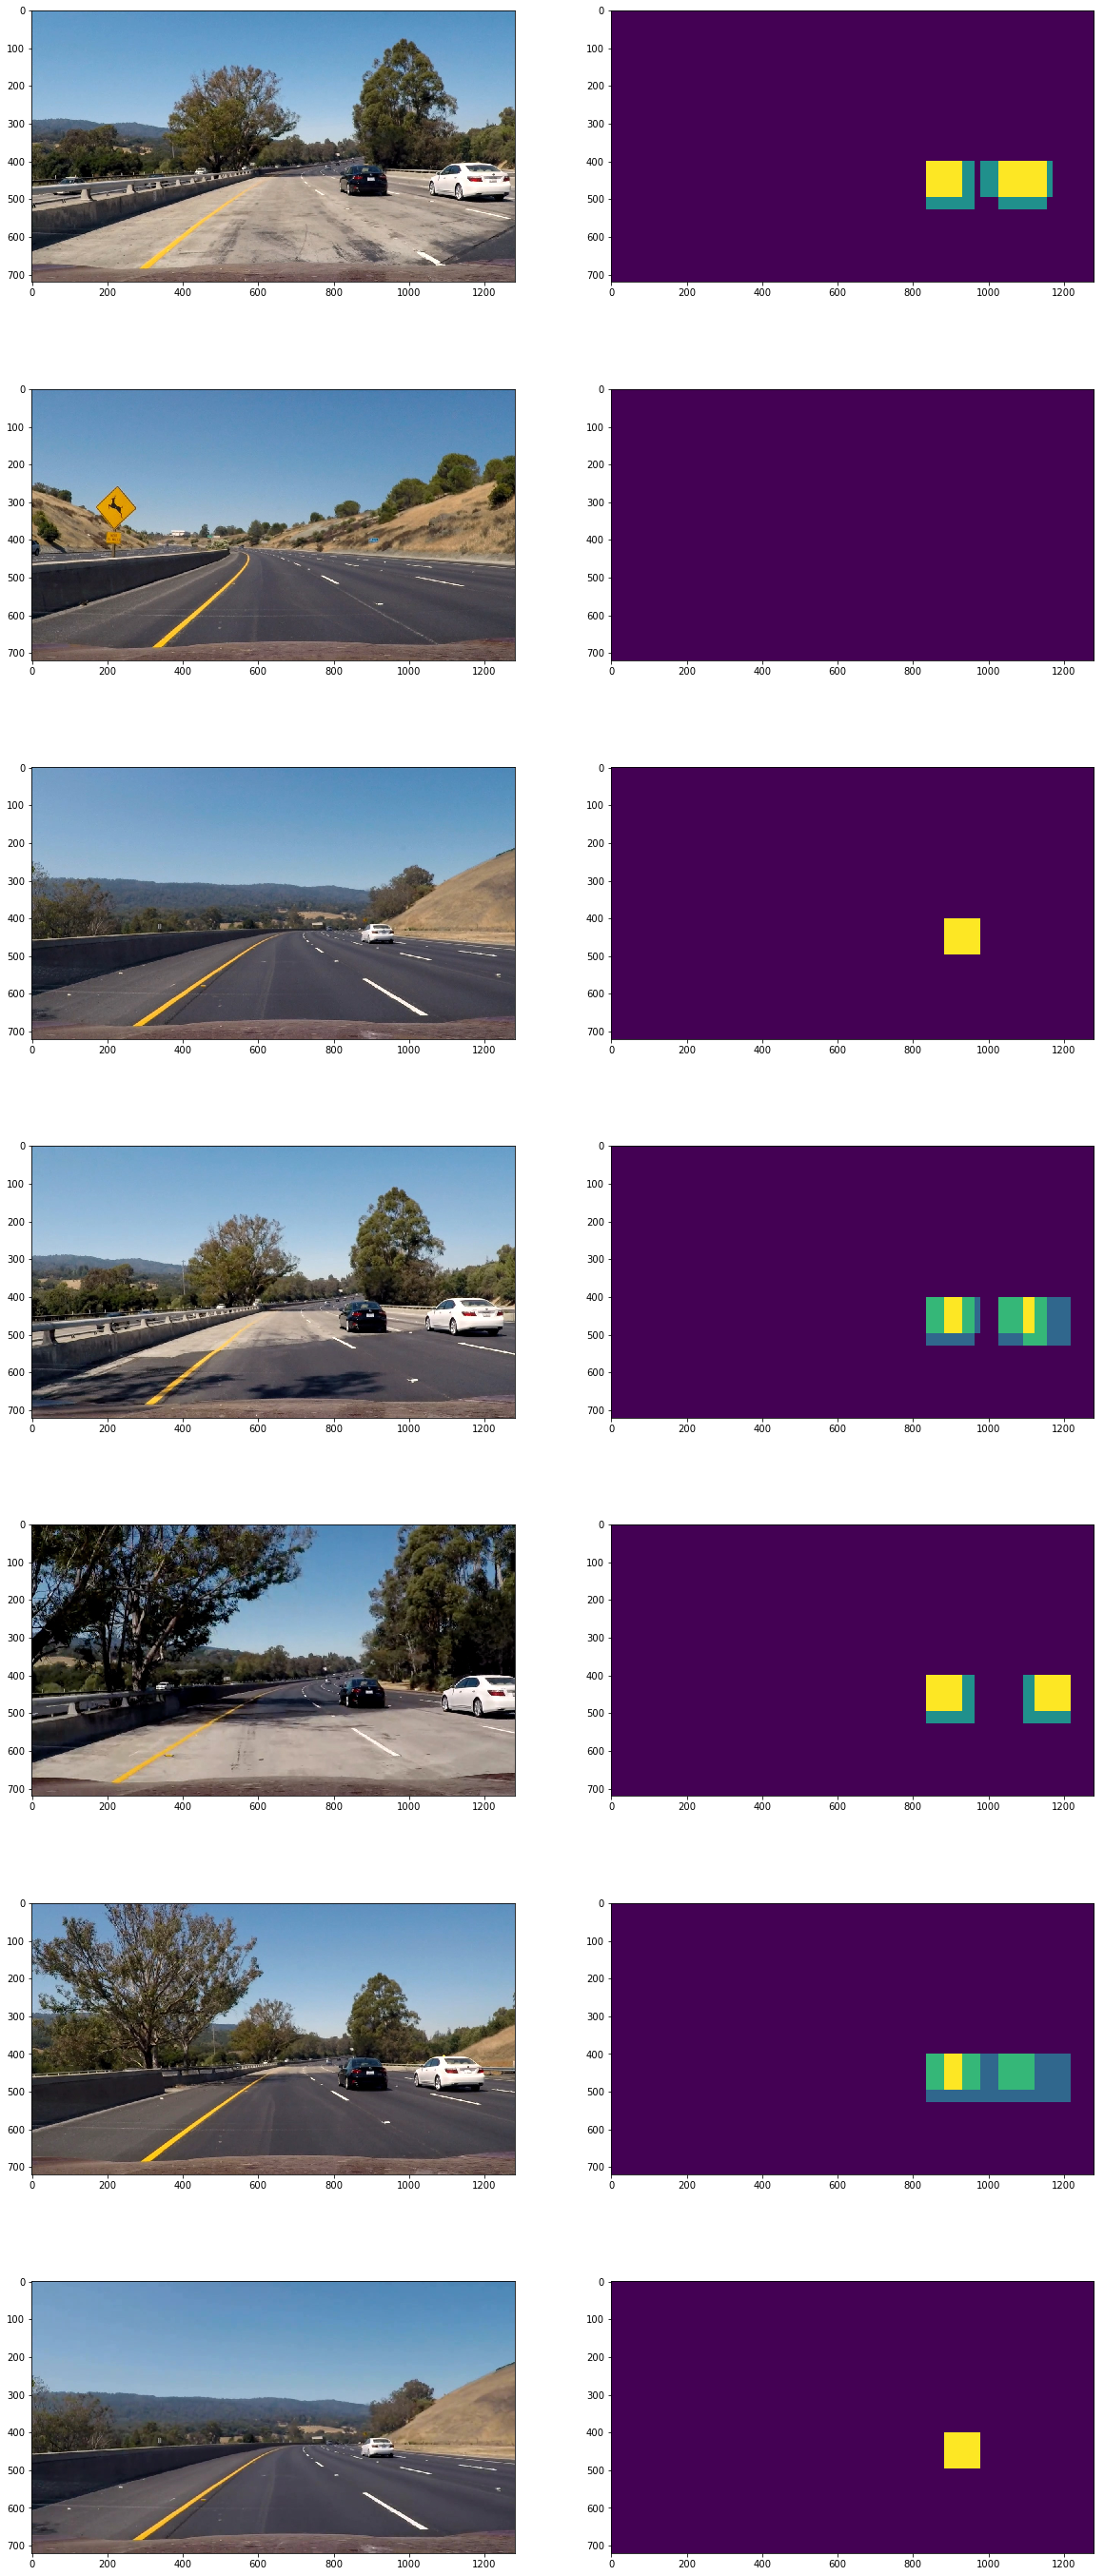

In [30]:
test_images = glob.glob('test_images/*.jpg')
test_images.append('test.jpg')

#Add sveral sliding window searches
car_dict = {}

image_list = []
for image in test_images:

    image = mpimg.imread(image)
    #image = mpimg.imread('test.jpg')

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    rectangles = []
    for i in range(0,len(iter_list)-3, 3):
        ystart = iter_list[i]
        ystop = iter_list[i+1]
        scale = iter_list[i+2]
        recs = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)  
        rectangles+=(recs)

    # Add heat to each box in box list
    heat_add = add_heat(np.copy(heat),rectangles)

    # Apply threshold to help remove false positives
    heat_thresh = apply_threshold(heat_add,0)

    # Visualize the heatmap when displaying    
    #heatmap = np.clip(heat_thresh, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat_thresh)
    draw_img, car_dict = draw_labeled_bboxes(np.copy(image), labels, car_dict)
    image_list.append(draw_img)
    image_list.append(heat_thresh)
    
rows = (len(image_list))//2
cols = 2

fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(20,50)
for i, image in enumerate(image_list):
    axs[int(i/cols)][i%cols].imshow(image)




In [13]:
car_dict = {}
iter_list=[400,500,1.5,400,550,2.0,400,600,3.5]

import time
def pipeline_final(image):
    start = time.time()
    global car_dict
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    rectangles = []
    for i in range(0,len(iter_list)-3, 3):
        ystart = iter_list[i]
        ystop = iter_list[i+1]
        scale = iter_list[i+2]
        recs = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)  
        rectangles+=(recs)
        
   
    # Add heat to each box in box list
    heat_add = add_heat(heat,rectangles)

    # Apply threshold to help remove false positives
    heat_thresh = apply_threshold(heat_add,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thresh, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    start_lanes = time.time()
    initial_lane,left_fit, right_fit, left_fitx, right_fitx, ploty, filtered_image, warped, deep_search, out_img = pipeline_lanes(np.copy(image))
    result=cv2.addWeighted(image, 1, initial_lane, 0.3, 1)
    end_lanes = time.time()
    
    draw_img, car_dict = draw_labeled_bboxes(np.copy(result), labels, car_dict)
    
    result  = add_diagnostic_image(draw_img, filtered_image, 0)
    result  = add_diagnostic_image(result, warped, 1)
    result  = add_diagnostic_image(result, deep_search, 2)
    result  = add_diagnostic_image(result, out_img, 3)
    
    end = time.time()
    fps_lanes = 1/(end_lanes-start_lanes)
    fps_cars = 1/((end - start)-(end_lanes-start_lanes))
    fps_text_cars = "FPS cars : %.2f" % fps_cars
    fps_text_lanes = "FPS lanes : %.2f" % fps_lanes

    result  = add_diagnostic_text(result, fps_text_lanes, 4, offset=50)
    result  = add_diagnostic_text(result, fps_text_cars, 4, offset=90)

    return result

In [14]:
def pipeline_lanes(img):

    global caches 
    
    is_blind = False
    left_fit, right_fit = None, None

    if caches:
        left_fit, right_fit, is_blind  = caches
        
    filtered_image = filter_image(img, is_blind)
       
    warped, filled = perspective_transform_with_filled_area(img, filtered_image)
    
    #The line below is added only for the first initial frame and for diagnostic purposes 
    ploty, left_fitx, right_fitx, left_fit, right_fit, deep_search = get_lane_rectangles(warped, left_fit, right_fit, is_blind)
    if not caches : 
        caches = [left_fit, right_fit, is_blind]

    if caches : 
        left_fit, right_fit, is_blind  = caches
        out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, is_blind = get_next_frame_lines(warped, left_fit, right_fit, is_blind)
        caches = [left_fit, right_fit, is_blind]

            

    result = inverse_perspective_transform(img, warped, left_fitx, right_fitx, ploty)
    

    return result, left_fit, right_fit, left_fitx, right_fitx, ploty, filtered_image, warped, deep_search,out_img

In [15]:
car_dict = {}

from moviepy.editor import VideoFileClip

# Reinitialize some global variables.
caches = [] 

output = 'custom_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) 
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video custom_output.mp4
[MoviePy] Writing video custom_output.mp4


100%|█████████▉| 1260/1261 [05:10<00:00,  3.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: custom_output.mp4 

Wall time: 5min 10s
